A routine to test OBIWAN on the COMP6v2 benchmark suite.

In [1]:
%cd ..

/Users/stefanomartire/GitHub/OBIWAN


In [2]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from data import datasetting
from architectures.net_utils import getModel

In [4]:
checkpoint_path = "results/models/obiwan_ani1Uani2_FH_VL_2.404"
model_name = "obiwan"

# COMP6v2 visualization

In [5]:
def cardinalityAndMaxSizeMeter(dataset):

    max_size = 0
    cardinality = 0

    for (coords, species), energy in iter(dataset):
        size = species.shape[0]
        if size > max_size:
            max_size = size
        cardinality += 1

    return cardinality, max_size

In [6]:
ds_path_list = glob.glob("data/datasets/comp6v2/*.h5")

ds_generator_list = [datasetting.COMP6v2Yielder(ds_path) for ds_path in ds_path_list]

In [7]:
ds_properties_list = [cardinalityAndMaxSizeMeter(ds) for ds in ds_generator_list]

In [8]:
ds_properties_dict = {
                        "-".join(ds_path.split("/")[-1].split(".")[0].split("-")[0:2]):
                            {"cardinality":cardinality, "max_size":max_size}
                        for ds_path, (cardinality, max_size) in zip(ds_path_list, ds_properties_list)
                        }

In [9]:
df = pd.DataFrame(ds_properties_dict)
df

,GDB-heavy11,S66x8-v1,GDB-heavy10,GDB-heavy07,DrugBank-SFCl,GDB-heavy08,GDB-heavy09,Tripeptides-v1,GDB11-08,DrugBank-testset,ANI-BenchMD,GDB11-07,GDB11-09,GDB11-11,GDB13-12,GDB13-13,GDB11-10,Tripeptides-sulphur
cardinality,9000,528,9000,9000,9824,9000,9000,1984,12000,13379,1791,12000,12000,11670,12000,12000,12000,1552
max_size,31,34,28,21,107,23,24,69,26,140,312,23,27,32,36,38,29,63


In [10]:
max_molecule_size = max([ds_properties_dict[ds_name]['max_size'] for ds_name in ds_properties_dict.keys()])
max_molecule_size

312

# The tests

In [ ]:
model = getModel(model_name=model_name, max_molecule_size=max_molecule_size)
model.loadWeights(checkpoint_path)

In [ ]:
errors_dict = {}

for ds_path in ds_path_list:

    # kcal/mol RMSE
    rmse = datasetting.OneTestOnCOMP6v2(ds_path=ds_path, model=model, print_error=True)

    # Store the error
    ds_name = "-".join(ds_path.split("/")[-1].split(".")[0].split("-")[0:2])
    errors_dict[ds_name] = rmse

In [ ]:
datasetting.addRowToCSV(df_path="results/comp6v2.csv", errors_dict=errors_dict, checkpoint_name=checkpoint_path.split("/")[-1])

# Visualise the results

In [11]:
benchmark_df = pd.read_csv("results/comp6v2.csv")

In [12]:
benchmark_df['mean'] = benchmark_df.drop(['model', 'ANI-BenchMD'], axis=1).mean(axis=1)

In [13]:
final_df = benchmark_df.sort_values(by=['mean']).head(2)
final_df

,model,ANI-BenchMD,DrugBank-SFCl,DrugBank-testset,GDB-heavy07,GDB-heavy08,GDB-heavy09,GDB-heavy10,GDB-heavy11,GDB11-07,GDB11-08,GDB11-09,GDB11-10,GDB11-11,GDB13-12,GDB13-13,S66x8-v1,Tripeptides-sulphur,Tripeptides-v1,mean
0,ANI-2x[0],5.764224,5.711286,4.122088,0.956558,1.211166,1.494669,1.870689,2.616729,1.110781,1.383602,1.787665,2.186736,2.927869,3.463652,4.102763,0.662568,2.937004,3.004615,2.444144
1,obiwan,15.256380,6.887354,6.092383,1.134423,1.385913,2.025012,2.358878,3.310564,1.121991,1.357220,1.681597,2.214078,2.989980,3.724943,4.543726,0.786151,3.087743,4.466458,2.892260


In [14]:
final_df = final_df.set_index('model').drop(['ANI-BenchMD'], axis=1)

In [16]:
anakin_mean = final_df.loc['ANI-2x[0]']['mean']
obiwan_mean = final_df.loc['obiwan']['mean']

anakin_legend = f'anakin (mean = {anakin_mean:.2f})'
obiwan_legend = f'obiwan (mean = {obiwan_mean:.2f})'

In [17]:
final_df = final_df.drop(['mean'], axis=1)

In [19]:
anakin_bars = final_df.loc['ANI-2x[0]'].to_numpy()
obiwan_bars = final_df.loc['obiwan'].to_numpy()

In [20]:
x_ticks = final_df.columns

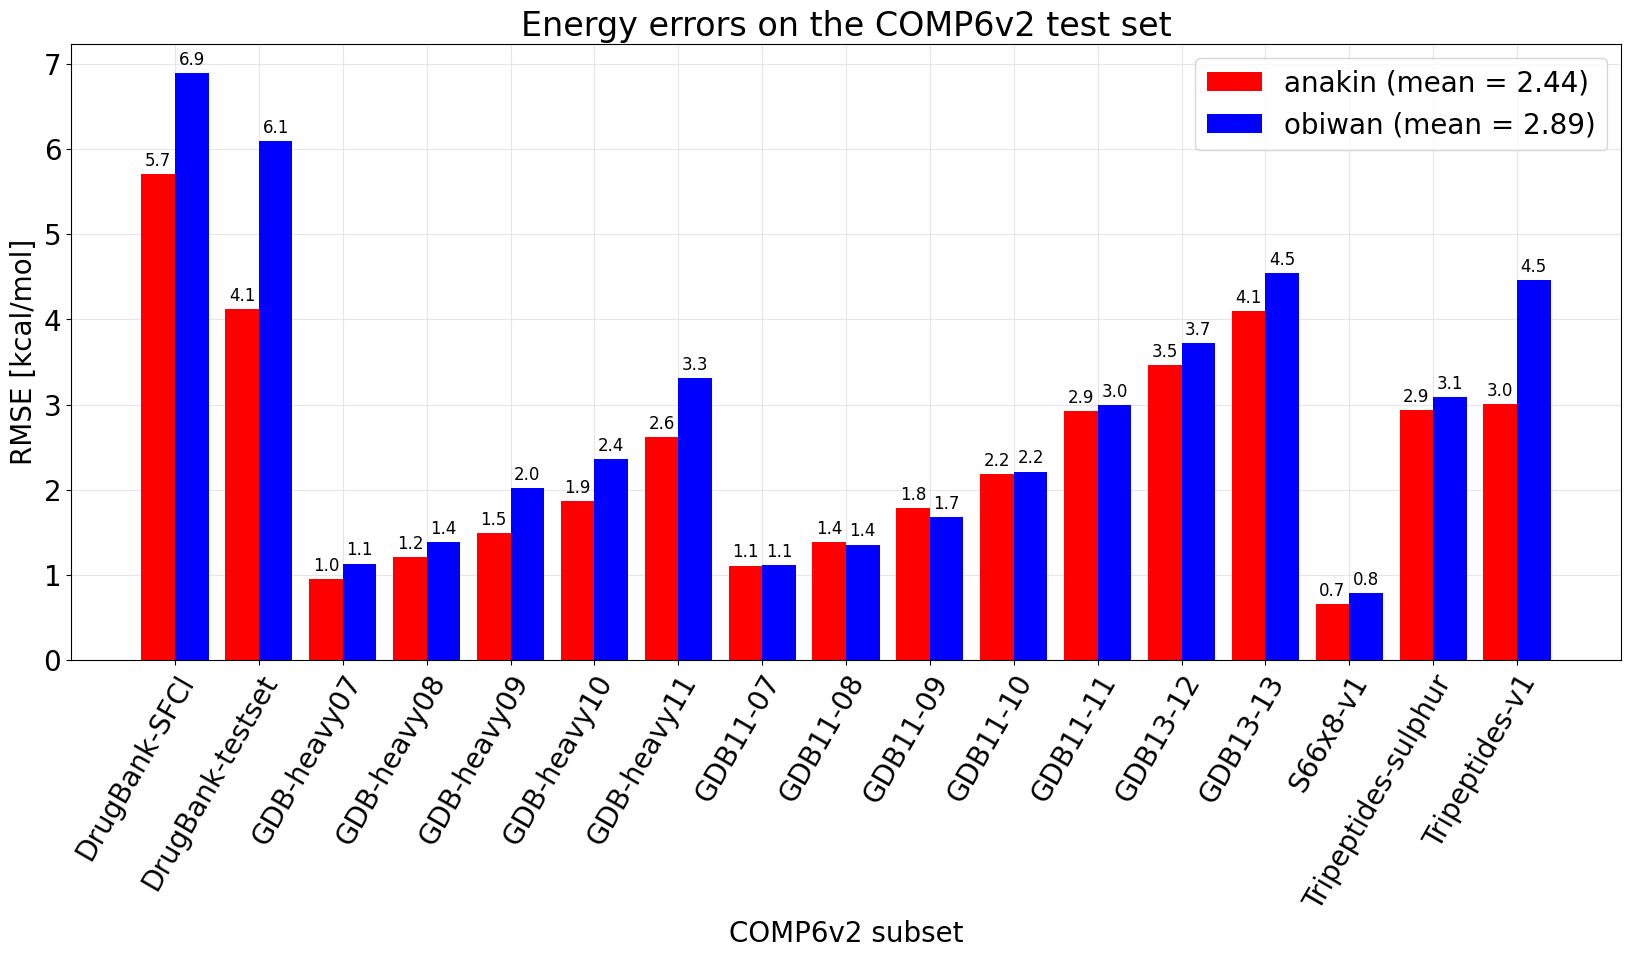

In [21]:
plt.rc('font', size=20)

x_axis = np.arange(len(x_ticks))

plt.bar(x=x_axis-0.2, height=anakin_bars, width=0.4, label=anakin_legend, color='red', zorder=2)
plt.bar(x=x_axis+0.2, height=obiwan_bars, width=0.4, label=obiwan_legend, color='blue', zorder=2)

# display the error on top of the bars, rounded to 1 decimal places
for i, v in enumerate(anakin_bars):
    plt.text(i-0.2, v + 0.05, f'{v:.1f}', ha='center', va='bottom', fontsize=12)

for i, v in enumerate(obiwan_bars):
    plt.text(i+0.2, v + 0.05, f'{v:.1f}', ha='center', va='bottom', fontsize=12)

plt.xticks(x_axis, x_ticks, rotation=60, ha='right', rotation_mode='anchor')
plt.xlabel('COMP6v2 subset')
plt.ylabel('RMSE [kcal/mol]')

plt.title('Energy errors on the COMP6v2 test set')

plt.legend()

plt.grid(color='0.9', zorder=1)

fig = plt.gcf()
fig.set_size_inches(20, 8)